In [32]:
%matplotlib inline

In [33]:
import scipy.optimize
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata

# Data
First get and preprocess the data. This time, we will use the complete data set and not just the samples for the numbers **`0`** and **`1`**.

Get data: contains 70k samples of which the last 10k are meant for testing

In [34]:
mnist = fetch_mldata('MNIST original', data_home='./data')

Prepare for concat

In [35]:
y_all = mnist.target[:, np.newaxis]

Intercept term to be added

In [36]:
intercept = np.ones_like(y_all)

Before the next step, we need to define this util function which normalizes the data.

In [37]:
def normalize_features(train, test):
    """Normalizes train set features to a standard normal distribution
    (zero mean and unit variance). The same procedure is then applied
    to the test set features.
    """
    train_mean = train.mean(axis=0)
    # +0.1 to avoid division by zero in this specific case
    train_std = train.std(axis=0) + 0.1
    
    train = (train - train_mean) / train_std
    test = (test - train_mean) / train_std
    return train, test

Now, normalize the data (zero mean and unit variance)

In [38]:
train_normalized, test_normalized = normalize_features(
    mnist.data[:60000, :],
    mnist.data[60000:, :],
)

Concat **`intercept`**, **`X`**, and **`y`** so that shuffling is easier in a next step

In [39]:
train_all = np.hstack((
    intercept[:60000],
    train_normalized,
    y_all[:60000],
))
test_all = np.hstack((
    intercept[60000:],
    test_normalized,
    y_all[60000:],
))

Shuffle the data. As mentioned in the [Logistic_Regression](http://nbviewer.ipython.org/github/HaFl/ufldl-tutorial-python/blob/master/Logistic_Regression.ipynb) notebook already, I don't think it's needed, but let's stick with the ufldl tutorial here.

In [40]:
np.random.shuffle(train_all)
np.random.shuffle(test_all)

Finally, get train and test data sets

In [41]:
train_X = train_all[:, :-1]
train_y = train_all[:, -1]

test_X = test_all[:, :-1]    
test_y = test_all[:, -1]

# Softmax Regression

Define some helpful variables and initial random theta values for all classes.

In [42]:
m, n = train_X.shape
k = np.unique(train_y).size
theta = np.random.rand(n, k) * 0.001

This **`indicator_mask`** will come in handy when computing the gradient later on.

In [43]:
indicator_mask = np.zeros((train_X.shape[0], theta.shape[1]), dtype=np.bool)
for i, idx in enumerate(train_y):
    indicator_mask[i][idx] = True

This is a helper function to keep the code DRY. It computes the probabilities of all classes for all samples.

In [44]:
def probs(theta, X, y):
    if theta.ndim == 1:
        theta = theta.reshape((theta.size / k, k))
    values = np.exp(X.dot(theta)) 
    sums = np.sum(values, axis=1)
    return (values.T / sums).T

The cost function of Softmax Regression. We could actually use the **`indicator_mask`** here instead of the loop at the end, but that would be computational overkill.

In [45]:
def cost_function(theta, X, y):
    log_probs = np.log(probs(theta, X, y))
    cost = 0
    for i in range(m):
         cost -= log_probs[i][y[i]]
    return cost

The gradient function of Softmax Regression.

In [46]:
def gradient(theta, X, y):
    gradient_matrix = -X.T.dot(indicator_mask - probs(theta, X, y))
    return gradient_matrix.flatten()

Alright, let's run the optimization. 100 iterations are enough here.

In [47]:
J_history = []

t0 = time.time()
res = scipy.optimize.minimize(
    fun=cost_function,
    x0=theta,
    args=(train_X, train_y),
    method='L-BFGS-B',
    jac=gradient,
    options={'maxiter': 100, 'disp': True},
    callback=lambda x: J_history.append(cost_function(x, train_X, train_y)),
)
t1 = time.time()

print('Optimization took {s} seconds'.format(s=t1 - t0))
optimal_theta = res.x.reshape((theta.size / k, k))

Optimization took 195.31115102767944 seconds


Plot the evolution of **`J`** (to make sure we did the right thing).

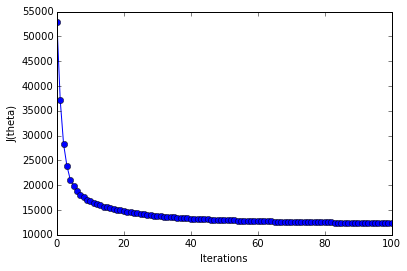

In [48]:
plt.plot(J_history, marker='o')
plt.xlabel('Iterations')
plt.ylabel('J(theta)')

Even the **`optimal_theta`** still results in a relatively high cost value **`J`**. That's not necessarily a bad sign, but rather the consequence of the model being more complex than e.g., Logistic Regression.

In [49]:
def accuracy(theta, X, y):
    correct = np.sum(np.argmax(probs(theta, X, y), axis=1) == y)
    return float(correct) / y.size

In [50]:
print('Training accuracy: {acc}'.format(acc=accuracy(res.x, train_X, train_y)))
print('Test accuracy: {acc}'.format(acc=accuracy(res.x, test_X, test_y)))

Training accuracy: 0.9435833333333333
Test accuracy: 0.9235
